In [1]:
import sys
import getopt
import os
import xarray as xr
import functools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as datetime
from matplotlib.dates import DateFormatter
import viz
import hist
import myfuncs
import importlib
importlib.reload(myfuncs)
from myparams import *

In [2]:
archive_path = '/home/adam/cloud/gdrive/postdoc/simulation_output'
arg_case_name,arg_start_year,arg_end_year = ('CZ2_I2000Clm51Fates_api25_resprout-branch_ca5pfts.C17e2acb6a-F99fefec7.2023-01-26',
                                            '1901','1903')

original_stdout = sys.stdout


#define paths to netcdf files
full_paths = myfuncs.getFullFilePaths(arg_case_name,arg_start_year,arg_end_year)
    
print("Importing data from netcdf....")
#Import the data into an xarray
ds = myfuncs.fix_time(xr.open_mfdataset(full_paths, decode_times=True,
                                preprocess=functools.partial(myfuncs.preprocess, fields=hist.fields)))

#get number of pfts
n_pfts = len(ds.fates_levpft)

print("DONE!")

Importing data from netcdf....
DONE!


In [7]:
output_path = archive_path + "/" + "processed_output_" + arg_case_name 

In [8]:
os.makedirs(output_path)

In [ ]:
def scpf_to_scls_by_pft(scpf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_scls = len(dataset.fates_levscls)
    ds_out = (scpf_var.rolling(fates_levscpf=n_scls, center=False)
            .construct("fates_levscls")
            .isel(fates_levscpf=slice(n_scls-1, None, n_scls))
            .rename({'fates_levscpf':'fates_levpft'})
            .assign_coords({'fates_levscls':dataset.fates_levscls})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    #ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    #ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)

### Function to dissagregate vars with dim CLLLPF

In [242]:
def clllpf_to_cl_ll_pf(clllpf_var):
    n_cl = 2
    n_ll = 30
    
    cl_llpf = (clllpf_var.rolling(
        fates_levcnlfpf = n_cl, center=False).construct("fates_levcl").isel(
        fates_levcnlfpf=slice(n_cl-1, None, n_cl))
        .rename({'fates_levcnlfpf':'fates_levllpf'}))
        #.assign_coords({'fates_levcl':np.array([1,2])})
        #.assign_coords({'fates_levllpf':np.arange(0,120)}))
    
    cl_ll_pf = (cl_llpf.rolling(
        fates_levllpf = n_ll, center=False).construct("fates_levll").isel(
        fates_levllpf=slice(n_ll-1, None, n_ll))
        .rename({"fates_levllpf":"fates_levpft"}))
        #.assign_coords({"fates_levll":np.arange(0,30)})
        #.assign_coords({"fates_levpft":dataset.fates_levpft}))   
    return(cl_ll_pf)
  
FATES_PARSUN_Z_CL_LL_PF = clllpf_to_cl_ll_pf(ds.FATES_PARSUN_Z_CLLLPF)
FATES_PARPROF_DIR_CL_LL_PF = clllpf_to_cl_ll_pf(ds.FATES_PARPROF_DIR_CLLLPF)
FATES_PARPROF_DIF_CL_LL_PF = clllpf_to_cl_ll_pf(ds.FATES_PARPROF_DIF_CLLLPF)

### PAR DIR available per m2

Why is incident PAR different for each pft in the same canopy layer and leaf layer?

There is some relationship to how LAI is distributed among the canopy layers?

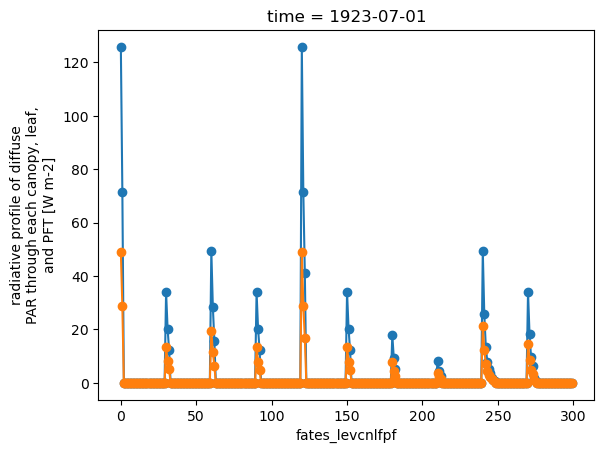

In [223]:
ds.FATES_PARPROF_DIR_CLLLPF.sel(time = "1923-07-01").plot(marker = "o")
ds.FATES_PARPROF_DIF_CLLLPF.sel(time = "1923-07-01").plot(marker = "o")

### Why does incident par at the top of canopy layer (for shrubs) change?

This variable seems to be affect by how much of each pft is in the canopy layer vs. the understory layer...

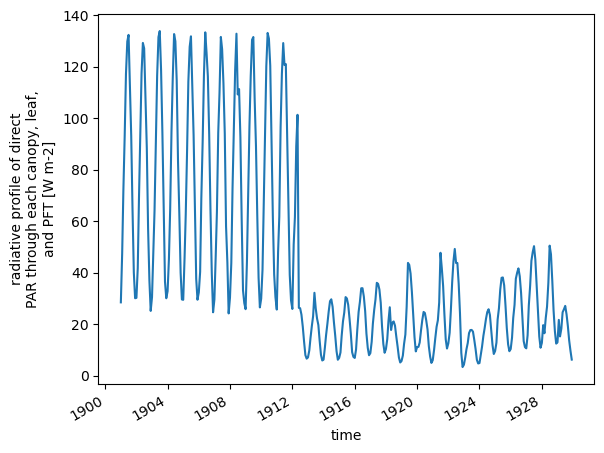

In [228]:
ds.FATES_PARPROF_DIR_CLLLPF.isel(fates_levcnlfpf = 180).plot()

### LAI in the sun

LAI in the sun is slightly lower for shrubs.

Sun LAI can get both par dif and par dir right?

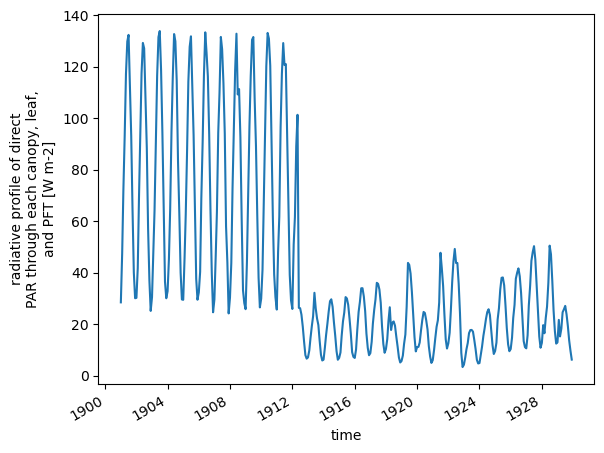

In [231]:
ds.FATES_PARPROF_DIR_CLLLPF.isel(fates_levcnlfpf = 180).plot()

#ds.FATES_LAISHA_Z_CLLLPF.sel(time = "1901-07-01").plot(marker = "o")
#ds.FATES_LAISHA_Z_CLLLPF.sel(time = "1901-07-01").sel(fates_levcnlfpf = slice(0,5)).plot(marker = "o")

### PAR sun absorbed

PAR absorbed by sun leaves.

Amount absorbed is much lower for shrubs and oaks because they have less crown area.

I assume this variable is m2 of ground area...

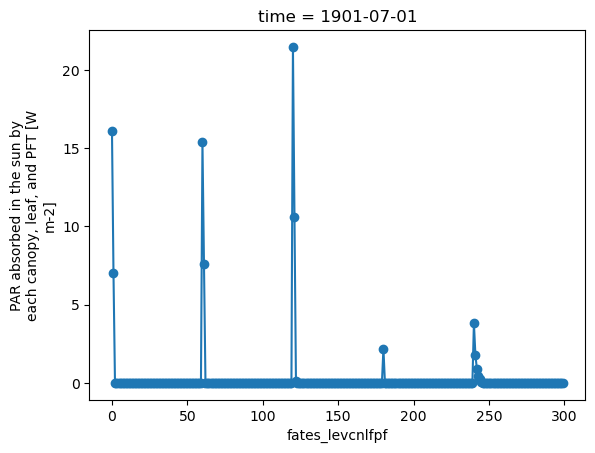

In [43]:
ds.FATES_PARSUN_Z_CLLLPF.sel(time = "1901-07-01").plot(marker = "o")

### Canopy crown area

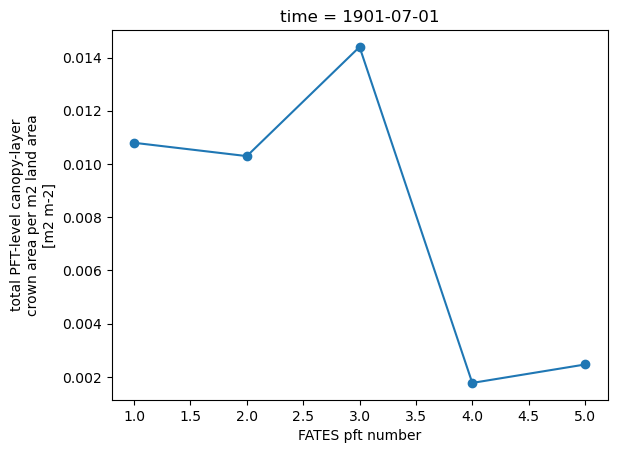

In [62]:
ds.FATES_CANOPYCROWNAREA_PF.sel(time = "1901-07-01").plot(marker = "o")

### Total par sun absorbed by shrubs per unit of crown area

Could I add par absorbed in shade to this? They are additive?

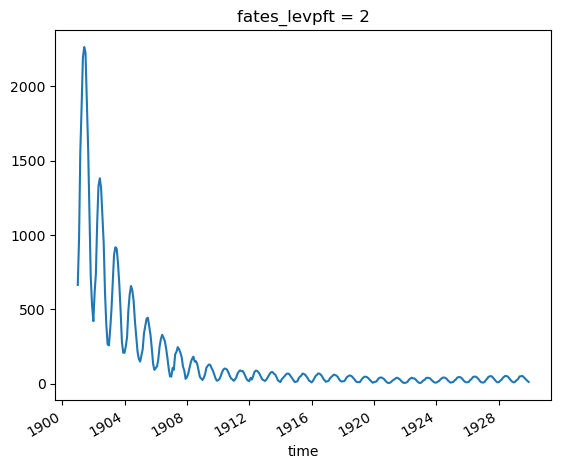

In [164]:
shrub_par_sun_z = FATES_PARSUN_Z_CL_LL_PF.isel(fates_levpft = 1).sum(axis = 1).sum(axis = 1)
shrub_crown_area = ds.FATES_CROWNAREA_PF.isel(fates_levpft = 1)
shrub_par_sun_z_m2_crown = shrub_par_sun_z / shrub_crown_area
shrub_par_sun_z_m2_crown.plot()

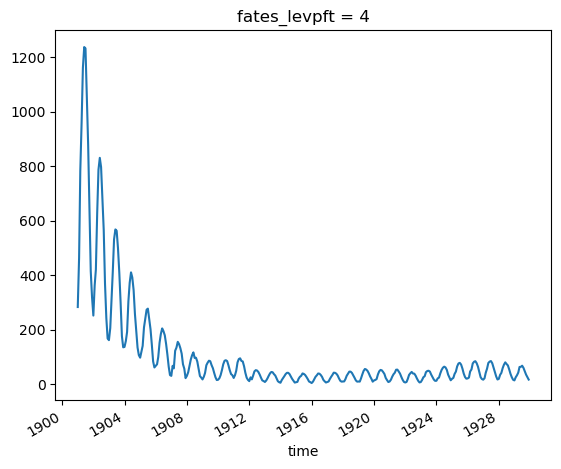

In [110]:
shrub_par_sun_z = FATES_PARSUN_Z_CL_LL_PF.isel(fates_levpft = 3).sum(axis = 1).sum(axis = 1)
shrub_crown_area = ds.FATES_CROWNAREA_PF.isel(fates_levpft = 3)
shrub_par_sun_z_m2_crown = shrub_par_sun_z / shrub_crown_area
shrub_par_sun_z_m2_crown.plot()

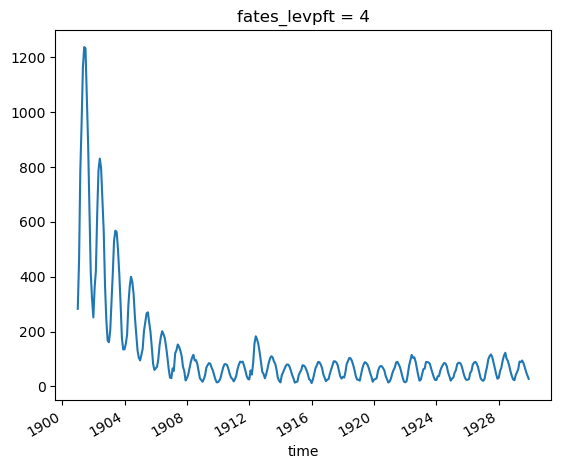

In [241]:
a = FATES_PARSUN_Z_CL_LL_PF.isel(fates_levpft = 3).isel(fates_levcl = 0).isel(fates_levll = 0)
ca = ds.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft = 3)

x = a/ca
x.plot()

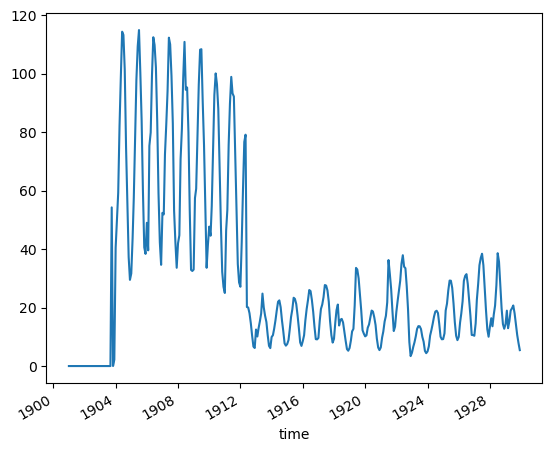

In [244]:
direct = FATES_PARPROF_DIR_CL_LL_PF.isel(fates_levpft = 3).isel(fates_levcl = 1).isel(fates_levll = 0)
diffuse = FATES_PARPROF_DIF_CL_LL_PF.isel(fates_levpft = 3).isel(fates_levcl = 1).isel(fates_levll = 0)

t = direct + diffuse
t.plot()
# shrub_par_top = FATES_PARPROF_DIR_CL_LL_PF.isel(fates_levpft = 3).isel(fates_levcl = 0).isel(fates_levll = 0)
# shrub_crown_area = ds.FATES_CROWNAREA_PF.isel(fates_levpft = 3)

# shrub_par_top / shrub_crown_area

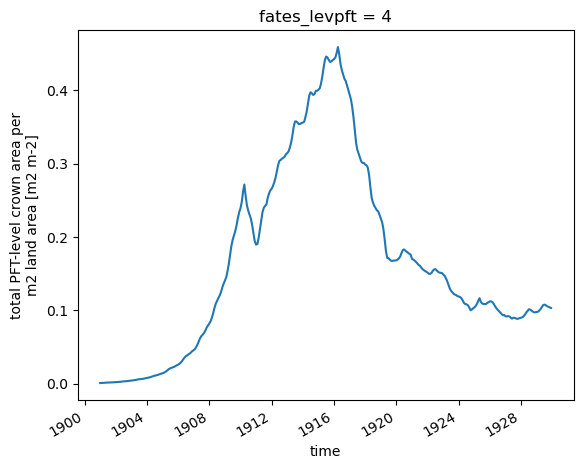

In [236]:
ds.FATES_CROWNAREA_PF.isel(fates_levpft = 3).plot()

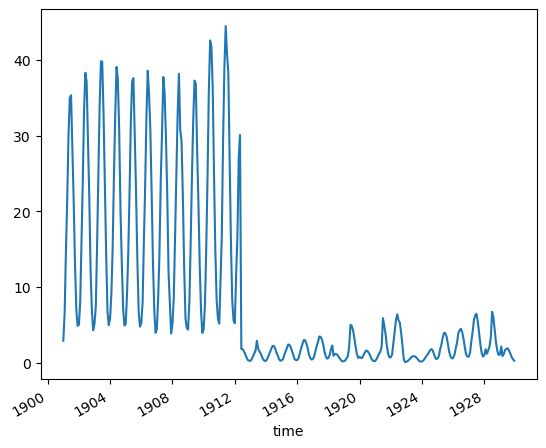

In [239]:
x = ds.FATES_LAISUN_Z_CLLLPF.isel(fates_levcnlfpf = 180) * FATES_PARPROF_DIR_CL_LL_PF.isel(fates_levpft = 3).isel(fates_levcl = 0).isel(fates_levll = 0)
x.plot()

In [ ]:
FATES_LAISHA_Z_CLLLPF.sel(time = "1901-07-01").plot(marker = "o")

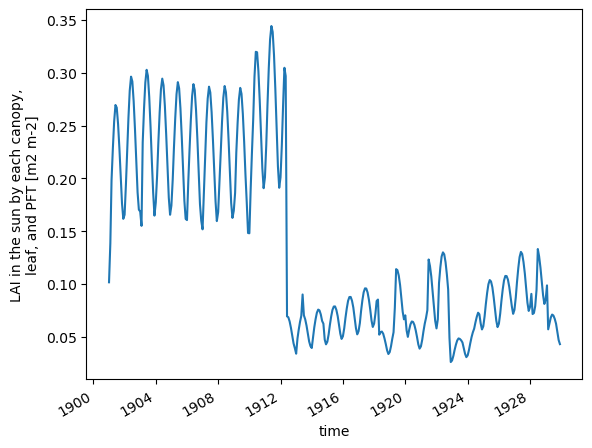

In [238]:
ds.FATES_LAISUN_Z_CLLLPF.isel(fates_levcnlfpf = 180).plot()

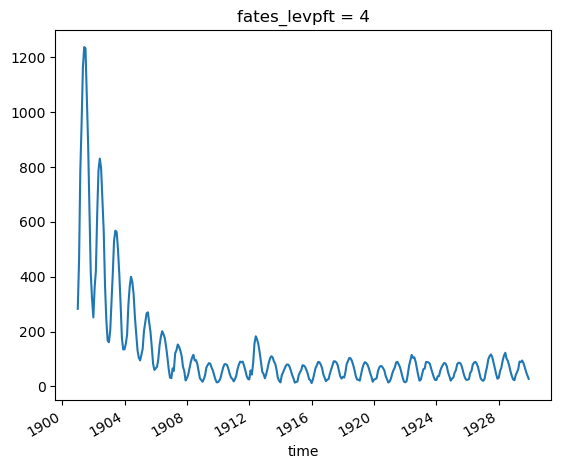

In [162]:
par_absorbed_canopy_per_unit_canopy_ca = FATES_PARSUN_Z_CL_LL_PF.isel(fates_levpft = 3).isel(fates_levcl = 0).isel(fates_levll = 0) / ds.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft = 3)
par_absorbed_canopy_per_unit_canopy_ca.plot()

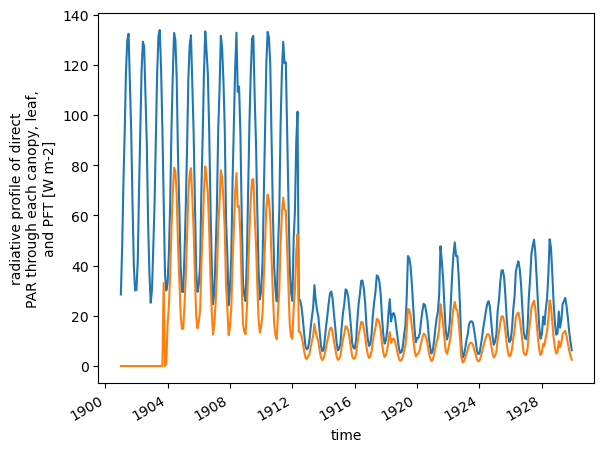

In [134]:
FATES_PARPROF_DIR_CL_LL_PF.isel(fates_levpft = 3, fates_levll = 0, fates_levcl = 0).plot(x = "time")
FATES_PARPROF_DIR_CL_LL_PF.isel(fates_levpft = 3, fates_levll = 0, fates_levcl = 1).plot(x = "time")

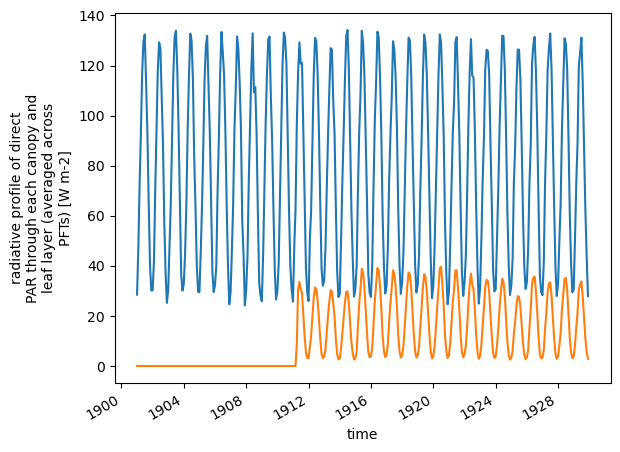

In [165]:
ds.FATES_PARPROF_DIR_CLLL.isel(fates_levcnlf = 0).plot()
ds.FATES_PARPROF_DIR_CLLL.isel(fates_levcnlf = 30).plot()
#.sel(time = "1901-01-01")
#ds.FATES_PARPROF_DIR_CLLL.sel(time = "1919-07-01").plot(marker = "o")

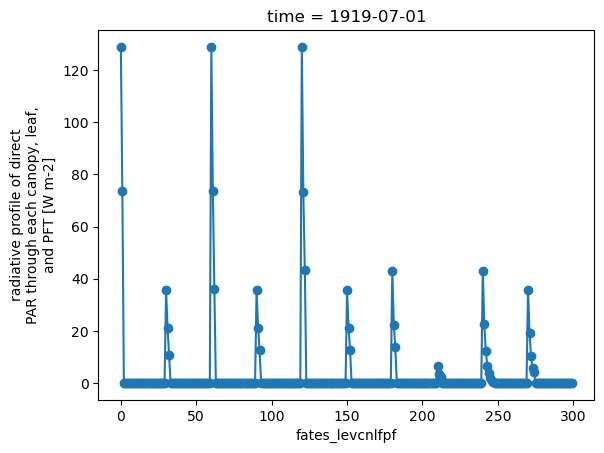

In [160]:
ds.FATES_PARPROF_DIR_CLLLPF.sel(time = "1919-07-01").plot(marker = "o")

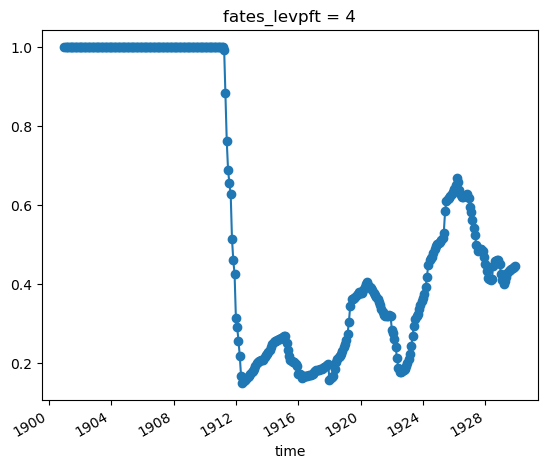

In [142]:
frac_in_canopy = ds.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft = 3) / (ds.FATES_CROWNAREA_PF.isel(fates_levpft = 3))
frac_in_canopy.plot(marker = 'o')

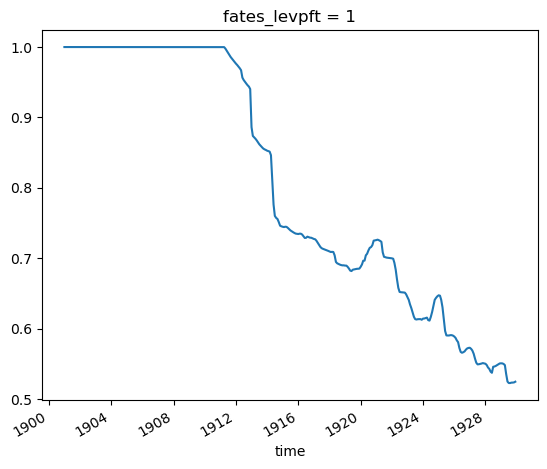

In [200]:
myfuncs.frac_in_canopy(0,ds).plot()

In [201]:
def weighted_avg_par(par_stream,frac_in_canopy):
    par_z = (par_stream.isel(fates_levcnlf = 0) * frac_in_canopy) +\
    (par_stream.isel(fates_levcnlf = 30) * (1 - frac_in_canopy))
    return(par_z)


def frac_in_canopy(xds):
    return(xds.FATES_CANOPYCROWNAREA_PF / xds.FATES_CROWNAREA_PF)

def incident_par(xds):
    f = frac_in_canopy(xds)

    par_z_dir = weighted_avg_par(xds.FATES_PARPROF_DIR_CLLL, f)
    par_z_dif = weighted_avg_par(xds.FATES_PARPROF_DIF_CLLL, f)
    par_total = par_z_dir + par_z_dif

    return(par_total)

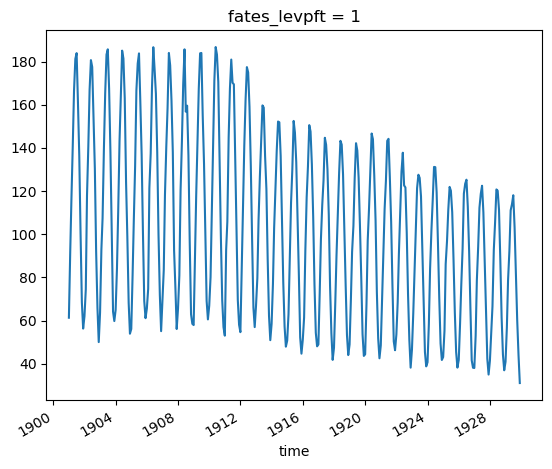

In [204]:
incident_par(ds).isel(fates_levpft = 0).plot()
#frac_in_canopy(ds)

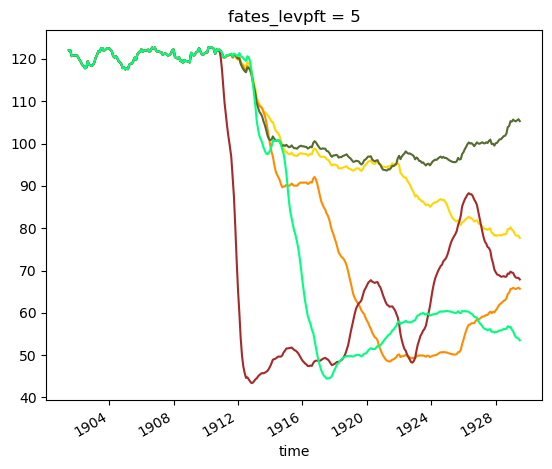

In [198]:
par = list(map(functools.partial(myfuncs.incident_par,xds = ds),range(n_pfts)))
for p in range(n_pfts):
    par[p].rolling(time=12, center=True).mean().plot(color = pft_colors[p])

#par[p].rolling(time=12, center=True).mean().plot()

53.33191
29.114075


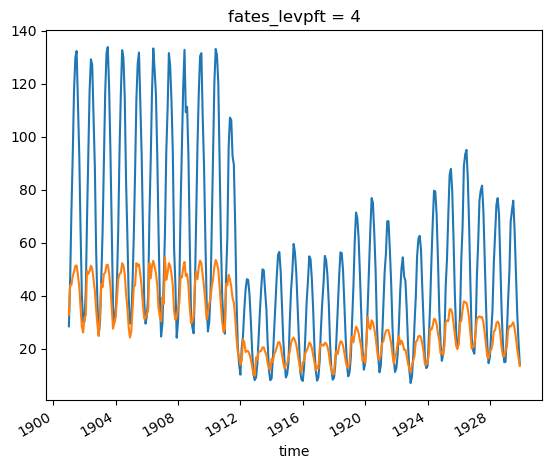

In [173]:
frac_in_canopy = ds.FATES_CANOPYCROWNAREA_PF.isel(fates_levpft = 3) / (ds.FATES_CROWNAREA_PF.isel(fates_levpft = 3))
mean_par_dir_incident_on_shrubs = (ds.FATES_PARPROF_DIR_CLLL.isel(fates_levcnlf = 0) * frac_in_canopy) + ds.FATES_PARPROF_DIR_CLLL.isel(fates_levcnlf = 30) * (1 - frac_in_canopy)
mean_par_dir_incident_on_shrubs.plot()

mean_par_dif_incident_on_shrubs = (ds.FATES_PARPROF_DIF_CLLL.isel(fates_levcnlf = 0) * frac_in_canopy) + ds.FATES_PARPROF_DIF_CLLL.isel(fates_levcnlf = 30) * (1 - frac_in_canopy)
mean_par_dif_incident_on_shrubs.plot()


print(mean_par_dir_incident_on_shrubs.values.mean(axis = 0))
print(mean_par_dif_incident_on_shrubs.values.mean(axis = 0))

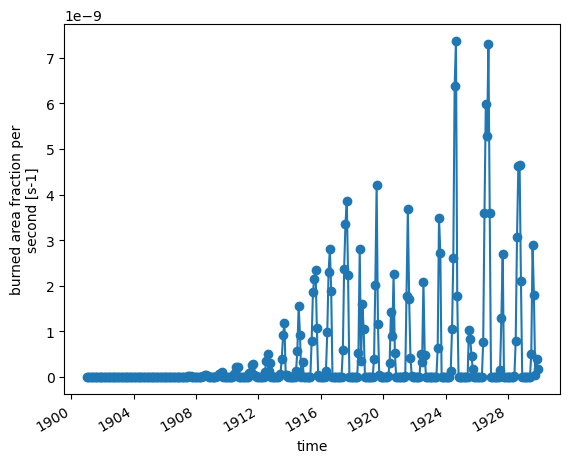

In [141]:
ds.FATES_BURNFRAC.plot(marker = "o")

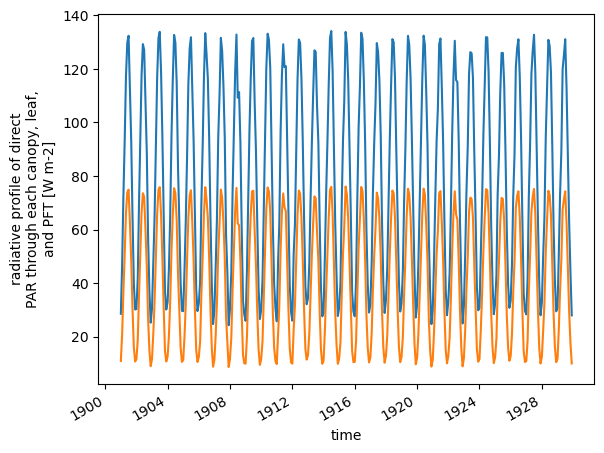

In [135]:
FATES_PARPROF_DIR_CL_LL_PF.isel(fates_levpft = 2, fates_levll = 0, fates_levcl = 0).plot(x = "time")
FATES_PARPROF_DIR_CL_LL_PF.isel(fates_levpft = 2, fates_levll = 0, fates_levcl = 1).plot(x = "time")

### PAR sun absorbed per m2 of sun leaf area

What if I wanted to do PAR sun aborved by unit leaf area and use LAI?

When I do PAR sun / LAI sun things don't seem to make sense.

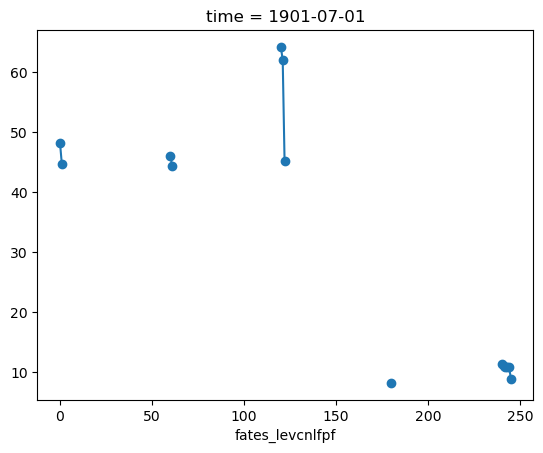

In [46]:
PAR_absorbed_per_m2_leaf_area = ds.FATES_PARSUN_Z_CLLLPF.sel(time = "1901-07-01") / ds.FATES_LAISUN_Z_CLLLPF.sel(time = "1901-07-01")
PAR_absorbed_per_m2_leaf_area.plot(marker = "o")

### PAR absorbed in the sun by shrubs per unit of shrub LAI in the sun

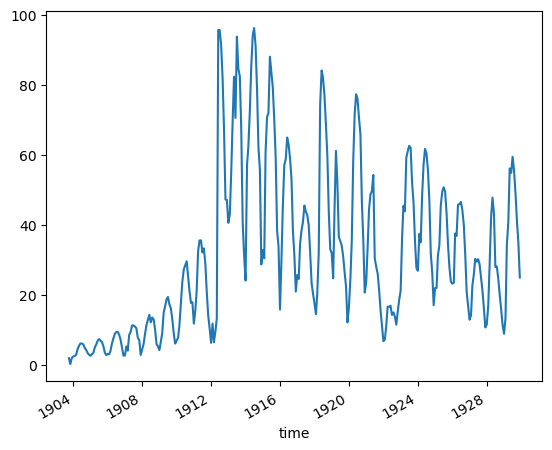

In [59]:
np.where(PAR_absorbed_per_m2_leaf_area.values == 8.177113)
shrub_absorb_top_leaf_per_m2_leaf = ds.FATES_PARSUN_Z_CLLLPF.isel(fates_levcnlfpf = 181) / ds.FATES_LAISUN_Z_CLLLPF.isel(fates_levcnlfpf = 181)
shrub_absorb_top_leaf_per_m2_leaf.plot()

### PAR absorbed in the shade by shrubs per unit of shrub LAI in the shade

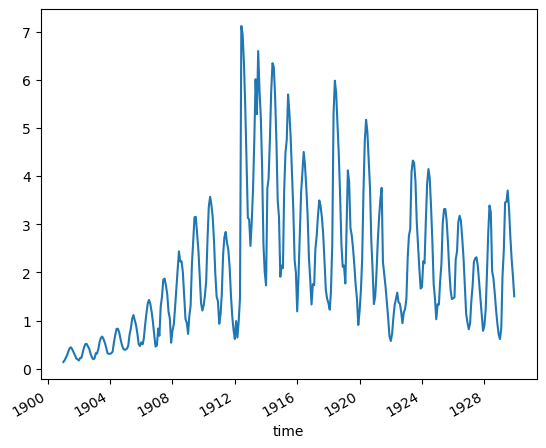

In [55]:
shrub_sha_absorb_top_leaf_per_m2_leaf = ds.FATES_PARSHA_Z_CLLLPF.isel(fates_levcnlfpf = 180) / ds.FATES_LAISHA_Z_CLLLPF.isel(fates_levcnlfpf = 180)
shrub_sha_absorb_top_leaf_per_m2_leaf.plot()

### PAR at the top shrub layer

So does this drop just reflect a reduction of shrubs in the canopy layer? And PAR is per m2 of ground area?

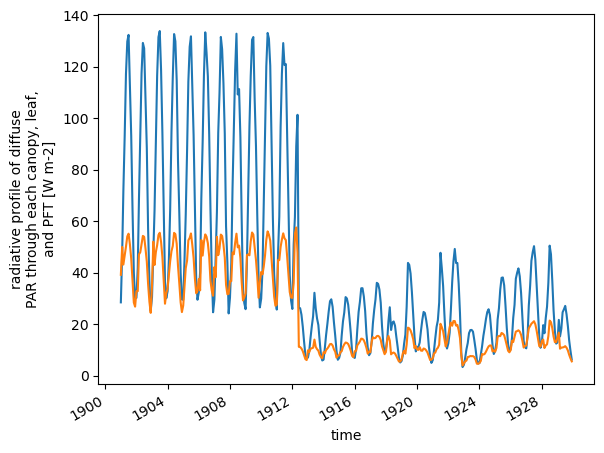

In [57]:
ds.FATES_PARPROF_DIR_CLLLPF.isel(fates_levcnlfpf = 180).plot()
ds.FATES_PARPROF_DIF_CLLLPF.isel(fates_levcnlfpf = 180).plot()

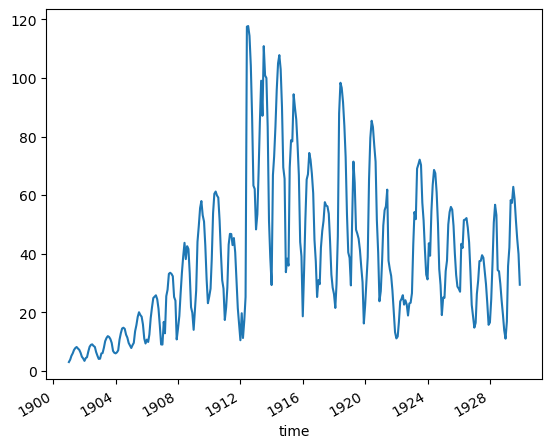

In [23]:
# def clllpf_to_cl_ll_pf(clllpf_var, dataset):
#     n_cl = 2
#     cl_llpf = (clllpf_var.rolling(fates_levcnlfpf = n_cl, center=False).construct("fates_levcl")
#         .isel(fates_levcnlfpf=slice(n_cl-1, None, n_cl))
#         .rename({'fates_levcnlfpf':'fates_levllpf'})
#         .assign_coords({'fates_levcl':np.array([1,2])})
#         .assign_coords({'fates_levllpf':np.arange(0,120)}))
    
#     cl_ll_pf = (cl_llpf.rolling(fates_levllpf = n_pfts, center=False).construct("fates_levpft")
#                 .isel(fates_levllpf=slice(n_pfts-1, None, n_pfts))
#                 .rename({"fates_levllpf":"fates_levll"})
#                 .assign_coords({"fates_levll":np.arange(0,30)})
#                 .assign_coords({"fates_levpft":dataset.fates_levpft}))
    
#     return cl_ll_pf

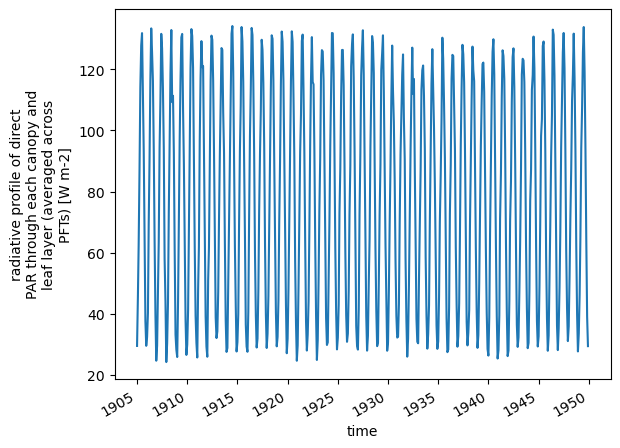

In [43]:
ds.FATES_PARPROF_DIR_CLLL.sel(fates_levcnlf = 0).plot()

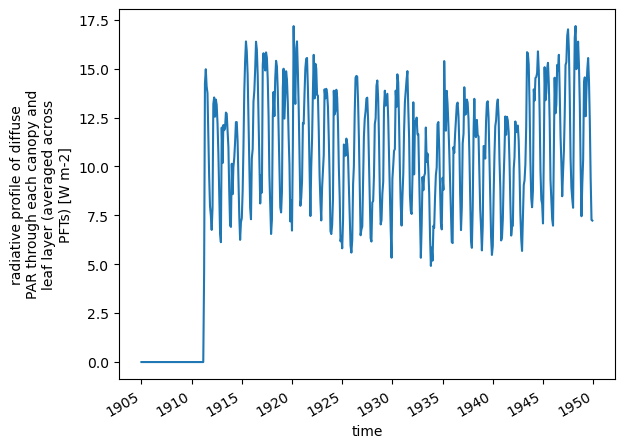

In [44]:
ds.FATES_PARPROF_DIF_CLLL.sel(fates_levcnlf = 30).plot()

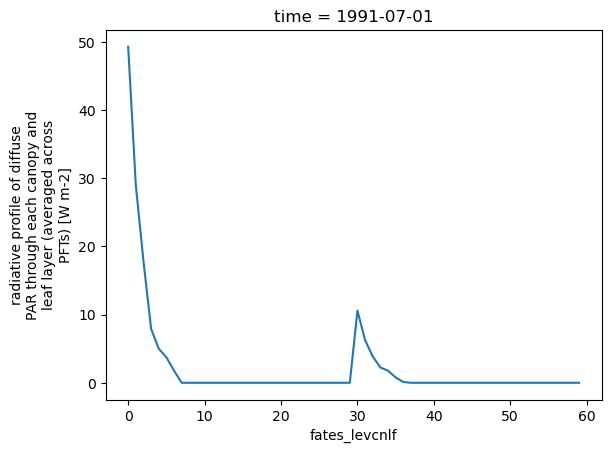

In [13]:
ds.FATES_PARPROF_DIR_CLLL.sel(time = "1991-07-01").plot()

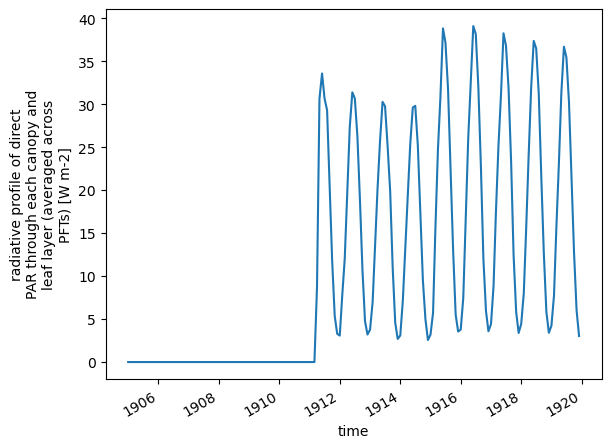

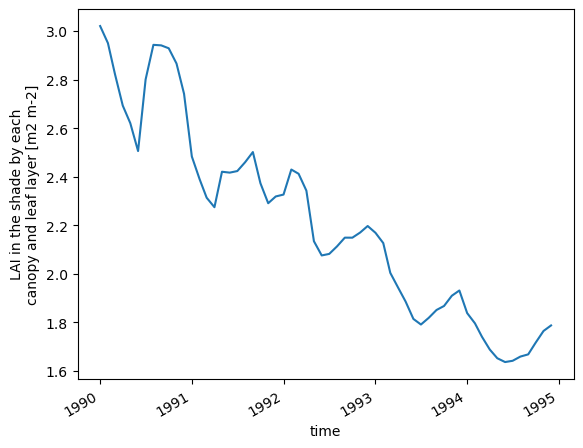

In [36]:
ds.FATES_LAISHA_Z_CLLL.sel(fates_levcnlf = 30).plot()

In [ ]:
# def clllpf_to_cl_ll_pf(clllpf_var, dataset):
#     n_cl = 2
#     cl_llpf = (clllpf_var.rolling(fates_levcnlfpf = n_cl, center=False).construct("fates_levcl")
#         .isel(fates_levcnlfpf=slice(n_cl-1, None, n_cl))
#         .rename({'fates_levcnlfpf':'fates_levllpf'})
#         .assign_coords({'fates_levcl':np.array([1,2])})
#         .assign_coords({'fates_levllpf':np.arange(0,120)}))
    
#     cl_ll_pf = (cl_llpf.rolling(fates_levllpf = n_pfts, center=False).construct("fates_levpft")
#                 .isel(fates_levllpf=slice(n_pfts-1, None, n_pfts))
#                 .rename({"fates_levllpf":"fates_levll"})
#                 .assign_coords({"fates_levll":np.arange(0,30)})
#                 .assign_coords({"fates_levpft":dataset.fates_levpft}))
    
#     return cl_ll_pf

In [ ]:
#params
n_ticks = 10
pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen']
pft_names = ["pine","cedar","fir","shrub","oak"]
fontsize = 12


#funcs
def plot_array(xarr,xds,n_pfts,conversion,title,ylabel,subplots = False):
    
    xarr = xarr * conversion
    nyears = len(np.unique(pd.to_datetime(xarr.time).year))
    nbase = max(nyears // n_ticks, 1)

    original_stdout = sys.stdout

    with open('log.txt', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        print('nyears: ',nyears)
        print('nbase: ',nbase)
        sys.stdout = original_stdout


    #prep data if it has multiplexed dimensions
    if xarr.dims == ('time', 'fates_levscpf'):
        xarr = myfuncs.scpf_to_scls_by_pft(xarr, xds)
        xarr = xarr.sum(axis=2)
    
    if subplots == False:

        fig, ax = plt.subplots(figsize = (7,7))
        
        if xarr.dims == ('time', 'fates_levpft'):

            for p in range(n_pfts):
                xarr.isel(fates_levpft=p).plot(x = "time",
                color = pft_colors[p],lw = 3,add_legend = True, label = pft_names[p])
                    
            plt.legend()

        if xarr.dims == ('time',):

            xarr.plot(x = "time", lw = 3)

    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=nbase))
    ax.set_ylabel(ylabel,fontsize = fontsize)
    ax.title.set_text(title)

    return(ax)

In [ ]:
def get_n_subplots(n_pfts):

    if (n_pfts % 2 == 0) | (n_pfts == 1):
        n_subplots = n_pfts
    else:
        n_subplots = n_pfts + 1
        
    if n_subplots == 1:
        ncol = 1
        nrow = 1

    else:
        ncol = 2
        nrow = n_subplots / ncol

    return (ncol,int(nrow))                       

In [ ]:
yrs_per_month = 1/12

def get_pft_level_per_capita_mort_rates(xarr,xds = ds,unit_conversion = yrs_per_month):
    
    xarr = xarr * unit_conversion
    
    if xarr.dims == ('time', 'fates_levscpf'):
        xarr = myfuncs.scpf_to_scls_by_pft(xarr, xds)
        xarr = xarr.sum(axis=2) #sum across size classes
        
    xarr_mort_per_cap = xarr / xds.FATES_NPLANT_PF
    
    return(xarr_mort_per_cap)

In [ ]:
def get_rate_table(arr_timeXpft, col_title, pft_names = pft_names):
    
    series = pd.DataFrame(arr_timeXpft.mean(axis = 0).values,
                           index = pft_names).sort_values(by = 0, ascending=False).reset_index()

    my_dict = {'pft':list(series.iloc[:,0]), col_title:list(series.iloc[:,1])}
    my_df = pd.DataFrame.from_dict(my_dict).set_index('pft')
    mort_tab = tabulate(my_df, headers='keys', tablefmt='psql')
    return(mort_tab)

In [ ]:
ds.fates_levscls

In [ ]:
mort_types = (ds.FATES_MORTALITY_CSTARV_SZPF, ds.FATES_MORTALITY_PF)
#get_pft_level_per_capita_mort_rates(ds.FATES_MORTALITY_CSTARV_SZPF,ds,yrs_per_month)
#test.mean(axis = 0).values
a,b = map(get_pft_level_per_capita_mort_rates,mort_types)

In [ ]:
#Per capita mortality
mort_types = (ds.FATES_MORTALITY_PF, ds.FATES_MORTALITY_BACKGROUND_SZPF,
              ds.FATES_MORTALITY_HYDRAULIC_SZPF, ds.FATES_MORTALITY_CSTARV_SZPF,
              ds.FATES_MORTALITY_FIRE_SZPF)


m_total, m_back, m_hydr, m_cstarv, m_fire = map(functools.partial(myfuncs.get_pft_level_per_capita_mort_rates,
                                               xds = ds, unit_conversion = yrs_per_month),mort_types)

In [ ]:
morts = (m_total, m_back, m_hydr, m_cstarv, m_fire)

mort_titles = ["Total Mortality Rate","Background Mortality Rate","Hydraulic Failure Mortality",
    "Carbon Starvation Mortality","Fire Mortality"]


In [ ]:
m_total_series = pd.Series(data = m_total.mean(axis = 0).values, index = pft_names).sort_values(ascending=False)
m_total_series.reset_index()

In [ ]:
from tabulate import tabulate


tabs = []
for i,m in enumerate(morts):
    series = pd.DataFrame(m.mean(axis = 0).values,
                       index = pft_names).sort_values(by = 0, ascending=False).reset_index()

    my_dict = {'pft':list(series.iloc[:,0]), mort_titles[i]:list(series.iloc[:,1])}
    my_df = pd.DataFrame.from_dict(my_dict).set_index('pft')
    
    tabs.append(tabulate(my_df, headers='keys', tablefmt='psql'))

#my_dict = {'a':[1,2,3,4], 'b':[1,2,3,5], 'c':[4,5,3,5]}


# mydf = pd.DataFrame.from_dict(my_dict)
# print(tabulate(mydf,))

# print(tabulate(mydf, headers='keys', tablefmt='psql'))

# print(tabulate(m_total_series, headers='keys', tablefmt='psql'))

In [ ]:
def plot_2d_array(xarr):

    #prep data
    df = xarr.to_dataframe()

    #define ticks
    nyears = len(np.unique(df.index.year))
    nbase = nyears // n_ticks

    if nbase < 1:
        nbase = 1

    #make plot
    #fig, ax = plt.subplots(figsize = (7,7))
    #ax.plot(df.iloc[:,0])
    
    
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=nbase))

    return(ax)

In [ ]:
basal_area = myfuncs.scpf_to_scls_by_pft(ds.FATES_BASALAREA_SZPF, ds).sum(axis = 2)

In [ ]:
df = basal_area.to_dataframe()
df.reset_index(level=1)


basa

In [ ]:
df = basal_area.to_dataframe()
df = df.reset_index(level=1)
nyears = len(np.unique(df.index.year))

In [ ]:
nyears

In [ ]:
n_ticks = 10
df = basal_area.to_dataframe()
df = df.reset_index(level=1)
nyears = len(np.unique(df.index.year))
nbase = nyears // n_ticks

if nbase < 1:
    nbase = 1

#make plot
fig, ax = plt.subplots(figsize = (7,7))

for p in range(n_pfts):
    basal_area.isel(fates_levpft=p).plot(x = "time", color = pft_colors[p],lw = 5,
                                         add_legend = True, label = pft_names[p])

ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(base=nbase))
plt.legend()

In [ ]:
basal_area.sum(axis =2).dims == ('time', 'fates_levpft')

In [ ]:
basal_area.dims

In [ ]:
ds.FATES_NCOHORTS.dims

In [ ]:
n_pfts = 5
#sum across size classes to get pft-level ba
basal_area_pf = basal_area.sum(axis=2)

#plot pft-level basal area over time
for p in range(n_pfts):
    ba_per_ha = basal_area_pf.isel(fates_levpft=p) * m2_per_ha
    ba_per_ha.plot(x = "time", color = pft_colors[p],lw = 5, add_legend = True,
                  )

plt.ylabel('BA [m-2 ha-1]', fontsize=12)
plt.title('Basal Area')

In [ ]:
viz.plot_2d_array(ds.FATES_NCOHORTS)

In [ ]:
my_dict = {'a':[1,2,3,4], 'b':[1,2,3,5], 'c':[4,5,3,5]}
my_dict

In [ ]:
my_dict = {'a':[1,2,3,4], 'b':[1,2,3,5], 'c':[4,5,3,5]}


mydf = pd.DataFrame(my_dict, orient = 'index', columns = ['mort','growth','rec'])

from tabulate import tabulate
outputList = my_dict.items()
table = outputList
print(tabulate(table))

In [ ]:
my_dict = {'a':[1,2,3,4], 'b':[1,2,3,5], 'c':[4,5,3,5]}


mydf = pd.DataFrame.from_dict(my_dict)
#print(tabulate(mydf,))

print(tabulate(mydf, headers='keys', tablefmt='psql'))

In [ ]:
print(tabulate(table))

In [ ]:
aw_fi = ds.FATES_FIRE_INTENSITY_BURNFRAC / (ds.FATES_BURNFRAC * s_per_day) / 1000

In [ ]:
aw_fi.mean()

In [ ]:
print(aw_fi.name)

In [ ]:
pd.to_datetime(ds.FATES_NCOHORTS.time).year

In [ ]:
len(ds.fates_levpft)

In [ ]:
ds.FATES_BURNFRAC.values.mean()